**Nina Dobša, zadnje uređivano 24.8.2025.**



In [ ]:
#!pip install datasets
#!pip install gensim
#!pip install matplotlib

# Imports

In [ ]:
from datasets import load_dataset, concatenate_datasets
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from google.colab import files
from sklearn.model_selection import train_test_split
import pandas as pd
import multiprocessing
import shutil
import os
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Emotion dataset import

In [ ]:
# Dataset import, the data will be used for model training
emotion_dataset = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
emotion_dataset.shape

(416809, 2)

In [ ]:
# Tokenization of sentences
tokenized_sentences = [simple_preprocess(sentence) for sentence in emotion_dataset["text"]]
print(tokenized_sentences[:5])

[['feel', 'awful', 'about', 'it', 'too', 'because', 'it', 'my', 'job', 'to', 'get', 'him', 'in', 'position', 'to', 'succeed', 'and', 'it', 'just', 'didn', 'happen', 'here'], ['im', 'alone', 'feel', 'awful'], ['ive', 'probably', 'mentioned', 'this', 'before', 'but', 'really', 'do', 'feel', 'proud', 'of', 'myself', 'for', 'actually', 'keeping', 'up', 'with', 'my', 'new', 'years', 'resolution', 'of', 'monthly', 'and', 'weekly', 'goals'], ['was', 'feeling', 'little', 'low', 'few', 'days', 'back'], ['beleive', 'that', 'am', 'much', 'more', 'sensitive', 'to', 'other', 'peoples', 'feelings', 'and', 'tend', 'to', 'be', 'more', 'compassionate']]


In [ ]:
# --- Callback for logging loss ---
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.previous_loss = 0

    def on_epoch_end(self, model):
        current_loss = model.get_latest_training_loss()
        epoch_loss = current_loss - self.previous_loss
        self.losses.append(epoch_loss)
        self.previous_loss = current_loss
        print(f"Epoch {self.epoch+1} - Train Loss: {epoch_loss:.2f}")
        self.epoch += 1


# Word2Vec fine tuning

In [ ]:
# --- Training SG Word2Vec model in 15 epochs ---
loss_logger_CBOW = LossLogger()

word2vec_model_CBOW_15 = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    min_count=1,
    epochs = 15,
    workers=multiprocessing.cpu_count(),
    sg=0,           # CBOW
    cbow_mean=0,    # sum of context vectors
    compute_loss=True,
    callbacks=[loss_logger_CBOW]
)

Epoch 1 - Train Loss: 1843306.25
Epoch 2 - Train Loss: 1628120.50
Epoch 3 - Train Loss: 1524575.75
Epoch 4 - Train Loss: 1496320.50
Epoch 5 - Train Loss: 1485868.50
Epoch 6 - Train Loss: 1331610.50
Epoch 7 - Train Loss: 1258448.00
Epoch 8 - Train Loss: 1223759.00
Epoch 9 - Train Loss: 1265783.00
Epoch 10 - Train Loss: 1236198.00
Epoch 11 - Train Loss: 1214908.00
Epoch 12 - Train Loss: 1170219.00
Epoch 13 - Train Loss: 923915.00
Epoch 14 - Train Loss: 879740.00
Epoch 15 - Train Loss: 767822.00


In [ ]:
word2vec_model_CBOW_15.save("CBOW_15.model")

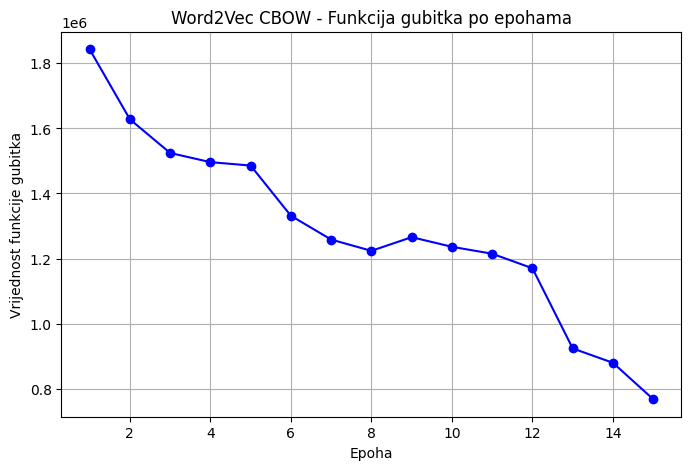

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(loss_logger_CBOW.losses)+1), loss_logger_CBOW.losses, marker='o', color='blue')
plt.xlabel("Epoha")
plt.ylabel("Vrijednost funkcije gubitka")
plt.title("Word2Vec CBOW - Funkcija gubitka po epohama")
plt.grid(True)
plt.show()

In [ ]:
# --- Training CBOW Word2Vec model in 10 epochs ---
loss_logger_CBOW = LossLogger()

word2vec_model_CBOW_10 = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    min_count=1,
    epochs = 10,
    workers=multiprocessing.cpu_count(),
    sg=0,           # CBOW
    cbow_mean=0,    # sum of context vectors
    compute_loss=True,
    callbacks=[loss_logger_CBOW]
)

word2vec_model_CBOW_10.save("CBOW_10.model")

Epoch 1 - Train Loss: 1796369.50
Epoch 2 - Train Loss: 1627421.25
Epoch 3 - Train Loss: 1557914.25
Epoch 4 - Train Loss: 1487336.00
Epoch 5 - Train Loss: 1446392.50
Epoch 6 - Train Loss: 1320733.50
Epoch 7 - Train Loss: 1273056.00
Epoch 8 - Train Loss: 1248711.00
Epoch 9 - Train Loss: 1151016.00
Epoch 10 - Train Loss: 1109523.00


In [ ]:
# --- Training CBOW Word2Vec model in 5 epochs ---
loss_logger_CBOW = LossLogger()

word2vec_model_CBOW_5 = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    min_count=1,
    epochs = 5,
    workers=multiprocessing.cpu_count(),
    sg=0,           # CBOW
    cbow_mean=0,    # sum of context vectors
    compute_loss=True,
    callbacks=[loss_logger_CBOW]
)

word2vec_model_CBOW_5.save("CBOW_5.model")

Epoch 1 - Train Loss: 1796030.88
Epoch 2 - Train Loss: 1625005.88
Epoch 3 - Train Loss: 1492256.75
Epoch 4 - Train Loss: 1449847.00
Epoch 5 - Train Loss: 1411767.00


In [ ]:
# --- Training SG Word2Vec model in 15 epochs ---
loss_logger_SG = LossLogger()

word2vec_model_SG_15 = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    epochs = 15,
    min_count=1,
    workers=multiprocessing.cpu_count(),
    sg=1,           # Skip-Gram
    compute_loss=True,
    callbacks=[loss_logger_SG]
)

Epoch 1 - Train Loss: 7666178.50
Epoch 2 - Train Loss: 5886666.50
Epoch 3 - Train Loss: 5465031.00
Epoch 4 - Train Loss: 5247566.00
Epoch 5 - Train Loss: 5165358.00
Epoch 6 - Train Loss: 4718216.00
Epoch 7 - Train Loss: 2854028.00
Epoch 8 - Train Loss: 2761824.00
Epoch 9 - Train Loss: 2758456.00
Epoch 10 - Train Loss: 2752776.00
Epoch 11 - Train Loss: 2637940.00
Epoch 12 - Train Loss: 2596364.00
Epoch 13 - Train Loss: 2541308.00
Epoch 14 - Train Loss: 2474376.00
Epoch 15 - Train Loss: 2358852.00


In [ ]:
word2vec_model_SG_15.save("SG_15.model")

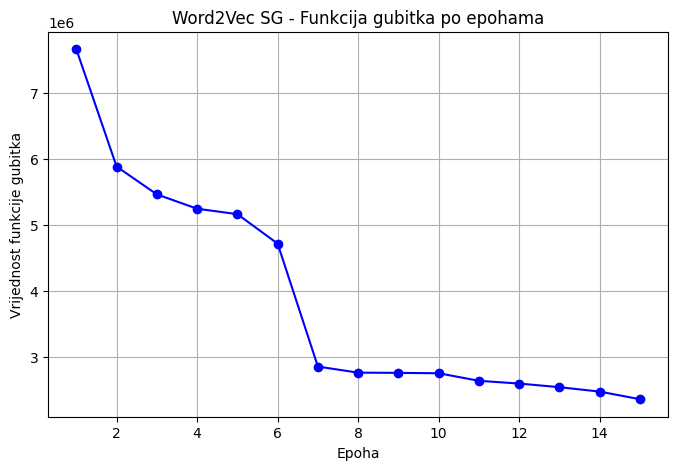

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(loss_logger_SG.losses)+1), loss_logger_SG.losses, marker='o', color='blue')
plt.xlabel("Epoha")
plt.ylabel("Vrijednost funkcije gubitka")
plt.title("Word2Vec SG - Funkcija gubitka po epohama")
plt.grid(True)
plt.show()

In [ ]:
# --- Training SG Word2Vec model in 10 epochs ---
loss_logger_SG = LossLogger()

word2vec_model_SG_10 = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    epochs = 10,
    min_count=1,
    workers=multiprocessing.cpu_count(),
    sg=1,           # Skip-Gram
    compute_loss=True,
    callbacks=[loss_logger_SG]
)

word2vec_model_SG_10.save("SG_10.model")

Epoch 1 - Train Loss: 7701040.50
Epoch 2 - Train Loss: 5717101.50
Epoch 3 - Train Loss: 5403986.00
Epoch 4 - Train Loss: 5181788.00
Epoch 5 - Train Loss: 5178808.00
Epoch 6 - Train Loss: 4786840.00
Epoch 7 - Train Loss: 2777364.00
Epoch 8 - Train Loss: 2712972.00
Epoch 9 - Train Loss: 2599696.00
Epoch 10 - Train Loss: 2488464.00


In [ ]:
# --- Training SG Word2Vec model in 5 epochs ---
loss_logger_SG = LossLogger()

word2vec_model_SG_5 = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,
    window=5,
    epochs = 5,
    min_count=1,
    workers=multiprocessing.cpu_count(),
    sg=1,           # Skip-Gram
    compute_loss=True,
    callbacks=[loss_logger_SG]
)

word2vec_model_SG_5.save("SG_5.model")

Epoch 1 - Train Loss: 7536857.50
Epoch 2 - Train Loss: 5930847.50
Epoch 3 - Train Loss: 5505921.00
Epoch 4 - Train Loss: 5145624.00
Epoch 5 - Train Loss: 5245410.00


In [ ]:
# Connecting with google drive where fine tuned models are stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import of NRC data from local file
emotion_lexicon = pd.read_excel("/content/drive/My Drive/data/NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations.xlsx", sheet_name="NRC-Lex-v0.92-word-translations")
# Printing number of rows and columns in emotion lexicon
emotion_lexicon.shape

(14182, 115)

In [ ]:
emotion_lexicon.columns

Index(['English (en)', 'Afrikaans (af)', 'Albanian (sq)', 'Amharic (am)',
       'Arabic (ar)', 'Armenian (hy)', 'Azeerbaijani (az)', 'Basque (eu)',
       'Belarusian (be)', 'Bengali (bn)',
       ...
       'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear',
       'Joy', 'Sadness', 'Surprise', 'Trust'],
      dtype='object', length=115)

In [ ]:
SG_5 = Word2Vec.load("SG_5.model")
SG_10 = Word2Vec.load("SG_10.model")
SG_15 = Word2Vec.load("SG_15.model")
CBOW_5 = Word2Vec.load("CBOW_5.model")
CBOW_10 = Word2Vec.load("CBOW_10.model")
CBOW_15 = Word2Vec.load("CBOW_15.model")

In [ ]:
def filter_vocab(lexicon, model):
    return lexicon[lexicon['English (en)'].isin(model.wv.key_to_index)]

filtered_lexicon_sg = filter_vocab(emotion_lexicon, SG_15)
filtered_lexicon_cbow = filter_vocab(emotion_lexicon, CBOW_15)

In [ ]:
def get_embeddings(words, model):
    return np.array([model.wv[word] for word in words])

In [ ]:
X_sg_5 = get_embeddings(filtered_lexicon_sg['English (en)'], SG_5)
X_cbow_5 = get_embeddings(filtered_lexicon_cbow['English (en)'], CBOW_5)
X_sg_10 = get_embeddings(filtered_lexicon_sg['English (en)'], SG_10)
X_cbow_10 = get_embeddings(filtered_lexicon_cbow['English (en)'], CBOW_10)
X_sg_15 = get_embeddings(filtered_lexicon_sg['English (en)'], SG_15)
X_cbow_15 = get_embeddings(filtered_lexicon_cbow['English (en)'], CBOW_15)

y_sg = filtered_lexicon_sg['Anger'].values
y_cbow = filtered_lexicon_cbow['Anger'].values

In [ ]:
def classify_embeddings(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_proba)

In [ ]:
acc_sg_5, f1_sg_5, roc_sg_5 = classify_embeddings(X_sg_5, y_sg)
acc_sg_10, f1_sg_10, roc_sg_10 = classify_embeddings(X_sg_10, y_sg)
acc_sg_15, f1_sg_15, roc_sg_15 = classify_embeddings(X_sg_15, y_sg)

acc_cbow_5, f1_cbow_5, roc_cbow_5 = classify_embeddings(X_cbow_5, y_cbow)
acc_cbow_10, f1_cbow_10, roc_cbow_10 = classify_embeddings(X_cbow_10, y_cbow)
acc_cbow_15, f1_cbow_15, roc_cbow_15 = classify_embeddings(X_cbow_15, y_cbow)

print(f"SG 5 epochs - Accuracy: {acc_sg_5:.4f}, F1: {f1_sg_5:.4f}, ROC AUC: {roc_sg_5:.4f}")
print(f"SG 10 epochs - Accuracy: {acc_sg_10:.4f}, F1: {f1_sg_10:.4f}, ROC AUC: {roc_sg_10:.4f}")
print(f"SG 15 epochs - Accuracy: {acc_sg_15:.4f}, F1: {f1_sg_15:.4f}, ROC AUC: {roc_sg_15:.4f}")

print(f"CBOW 5 epochs - Accuracy: {acc_cbow_5:.4f}, F1: {f1_cbow_5:.4f}, ROC AUC: {roc_cbow_5:.4f}")
print(f"CBOW 10 epochs - Accuracy: {acc_cbow_10:.4f}, F1: {f1_cbow_10:.4f}, ROC AUC: {roc_cbow_10:.4f}")
print(f"CBOW 15 epochs - Accuracy: {acc_cbow_15:.4f}, F1: {f1_cbow_15:.4f}, ROC AUC: {roc_cbow_15:.4f}")

SG 5 epochs - Accuracy: 0.9123, F1: 0.2166, ROC AUC: 0.7377
SG 10 epochs - Accuracy: 0.9086, F1: 0.2313, ROC AUC: 0.7504
SG 15 epochs - Accuracy: 0.9114, F1: 0.2474, ROC AUC: 0.7563
CBOW 5 epochs - Accuracy: 0.9102, F1: 0.0750, ROC AUC: 0.6959
CBOW 10 epochs - Accuracy: 0.9106, F1: 0.1053, ROC AUC: 0.7153
CBOW 15 epochs - Accuracy: 0.9114, F1: 0.1344, ROC AUC: 0.7237


In [ ]:
# Connecting with google drive where fine tuned / trained models are stored

cbow_path = '/content/drive/MyDrive/modeli/CBOW_10.model'
sg_path   = '/content/drive/MyDrive/modeli/SG_15.model'

CBOW_10.save(cbow_path)
SG_15.save(sg_path)